In [106]:
import scipy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import statistics
from scipy.optimize import least_squares

In [95]:
SNR = 30
n_elements = 32
c1 = 0.5
c2 = 0.5
T21 = 10
T22 = 200

tdata = np.linspace(8, 8*n_elements, num = n_elements)

Estimated tau values: 10.448839310030834 202.1162272110049


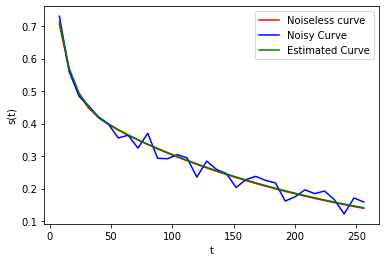

In [175]:
#create a simple, nonlinear model
#Here, a biexponential, s(t)

#Two parameter definition of s(t)
def s(t, tau_1, tau_2): 
    return c1*np.exp(-t/tau_1) + c2*np.exp(-t/tau_2)

noiseless_curve = s(tdata, T21, T22)

plt.plot(tdata, noiseless_curve, 'r')
plt.ylabel('s(t)')
plt.xlabel('t')

#Now add noise, here, Gaussian zero mean noise of some variance
def noise(sd):
    return np.random.normal(0, sd, n_elements)

#Set standard deviation to 0.01
noise_sd = noiseless_curve[0]/SNR
noisy_curve = noiseless_curve + noise(noise_sd)

plt.plot(tdata, noisy_curve, 'b')

#Recover tau_1 and tau_2 from the noisy curve
popt, pcov = curve_fit(s, tdata, noisy_curve)

#Convention tau_1 < tau_2 and cn values follow
if popt[1] > popt[0]:
    estimated_tau_1 = popt[0]
    estimated_tau_2 = popt[1]
else:
    estimated_tau_1 = popt[1]
    estimated_tau_2 = popt[0]

print('Estimated tau values:', estimated_tau_1, estimated_tau_2)

#Plot estimated curve on top of the original and noisy curves
estimated_curve = s(tdata, estimated_tau_1, estimated_tau_2)
plt.plot(tdata, estimated_curve, 'g')

plt.legend(['Noiseless curve', 'Noisy Curve', 'Estimated Curve'])
plt.show()

In [21]:
#Estimated Tau values after 5 iterations:
estimated_tau_1_values = np.array([30.3, 30.1, 29.4, 29.1, 29.3])
estimated_tau_2_values = np.array([100.2, 99.1, 101.2, 102.3, 101.8])

tau_1_error = estimated_tau_1_values - 30
tau_2_error = estimated_tau_2_values - 100

#Calculate the bias
tau_1_bias = np.mean(tau_1_error)
tau_2_bias = np.mean(tau_2_error)
print("Bias in estimated tau:", tau_1_bias, tau_2_bias)

#Calculate the variance
tau_1_variance = statistics.pvariance(estimated_tau_1_values)
tau_2_variance = statistics.pvariance(estimated_tau_2_values)
print("Variance in estimated tau:", tau_1_variance, tau_2_variance)

Bias in estimated tau: -0.35999999999999943 0.9199999999999988
Variance in estimated tau: 0.22240000000000018 1.317600000000001


In [12]:
#Test identity that MSE = Bias^2 + variance
MSE_1 = (1/5)*np.sum(np.square(tau_1_error))
MSE_2 = (1/5)*np.sum(np.square(tau_2_error))
print(MSE_1, MSE_2)
print(tau_1_bias**2 + tau_1_variance, tau_2_bias**2 + tau_2_variance)

0.3519999999999998 2.1639999999999993
0.35199999999999976 2.163999999999999


## Try using least_squares

In [166]:
m0 = [40, 100]

def G(m, t):
    return c1*np.exp(-t/m[0]) + c2*np.exp(-t/m[1])

def noise(sd):
    return np.random.normal(0, sd, n_elements)

d = G([T21, T22], tdata) + noise(noise_sd)

def residual(m):
    return G(m, tdata) - d

estimated = least_squares(residual, m0)

def reg_least_squares(reg_param):
    def G_tilde(m, t):
        return np.append(G(m, t), [reg_param*m[0], reg_param*m[1]])
    
    d_tilde = np.append(d, [0,0])
    def residual_reg(m):
        return G_tilde(m, tdata) - d_tilde
    
    return least_squares(residual_reg, m0).x

In [171]:
reg_least_squares(0)

array([  8.53313544, 206.40072727])

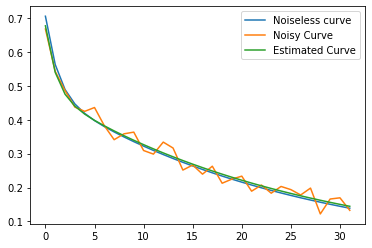

In [167]:
plt.plot(G([T21, T22], tdata))
plt.plot(d)
plt.plot(G(estimated.x, tdata))
plt.legend(['Noiseless curve', 'Noisy Curve', 'Estimated Curve'])

plt.show()

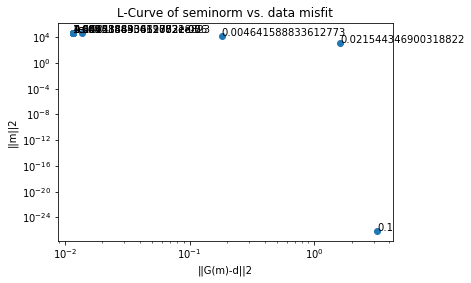

In [178]:
n_lambdas = 10
lambdas = np.logspace(-7, -1, n_lambdas)

solution_norm = []
residual_norm = []

for lam in lambdas:
    params = reg_least_squares(lam)
    
    solution_norm.append((params**2).sum())
    residual_norm.append(((G(params, tdata)-d)**2).sum())

plt.scatter(residual_norm, solution_norm)
plt.title('L-Curve of seminorm vs. data misfit')
plt.ylabel('||m||2')
plt.xlabel('||G(m)-d||2')
plt.xscale('log')
plt.yscale('log')

for k, label in enumerate(lambdas):
    plt.text(residual_norm[k], solution_norm[k], label)
    
plt.show()